In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
warnings.simplefilter('ignore')
matplotlib.rcParams['figure.dpi'] = 100
sns.set()
%matplotlib inline

In [2]:
BASE = "D:/pythonHomework/ashrae-energy-prediction/"
building = pd.read_csv(BASE+'building_metadata.csv')
weather_train = pd.read_csv(BASE+'weather_train.csv')
weather_test = pd.read_csv(BASE+'weather_test.csv')
train = pd.read_csv(BASE+'train.csv')
test = pd.read_csv(BASE+'test.csv')

In [3]:
train = train.merge(building, on='building_id', how='left')
test = test.merge(building, on='building_id', how='left')

train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')
test = test.merge(weather_test, on=['site_id', 'timestamp'], how='left')
del weather_train, weather_test,building
gc.collect();

In [5]:
# Saving some memory
d_types = {'building_id': np.int16,
          'meter': np.int8,
          'site_id': np.int8,
          'primary_use': 'category',
          'square_feet': np.int32,
          'year_built': np.float16,
          'floor_count': np.float16,
          'air_temperature': np.float32,
          'cloud_coverage': np.float16,
          'dew_temperature': np.float32,
          'precip_depth_1_hr': np.float16,
          'sea_level_pressure': np.float32,
          'wind_direction': np.float16,
          'wind_speed': np.float32}

for feature in d_types:
    train[feature] = train[feature].astype(d_types[feature])
    test[feature] = test[feature].astype(d_types[feature])
    
train["timestamp"] = pd.to_datetime(train["timestamp"])
test["timestamp"] = pd.to_datetime(test["timestamp"])
gc.collect();

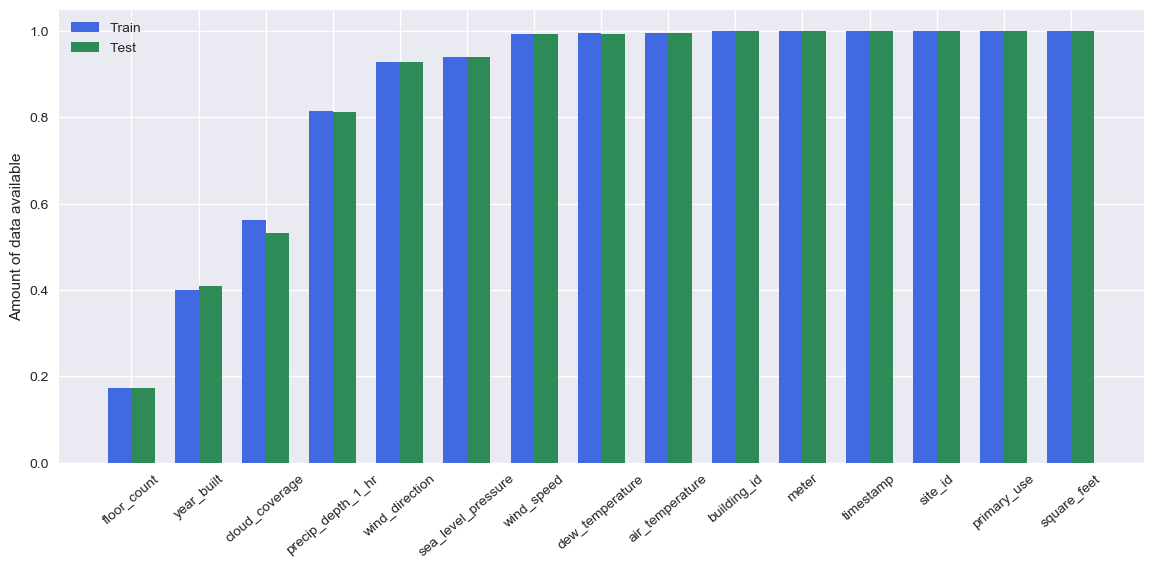

In [6]:
# Amount of data and NaNs

train_data = (train.count() / len(train)).drop('meter_reading').sort_values().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = (test.count() / len(test)).drop('row_id').sort_values().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Amount of data available');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels((train.count() / len(train)).drop('meter_reading').sort_values().index, rotation=40)
axes.legend([tr, tt], ['Train', 'Test']);

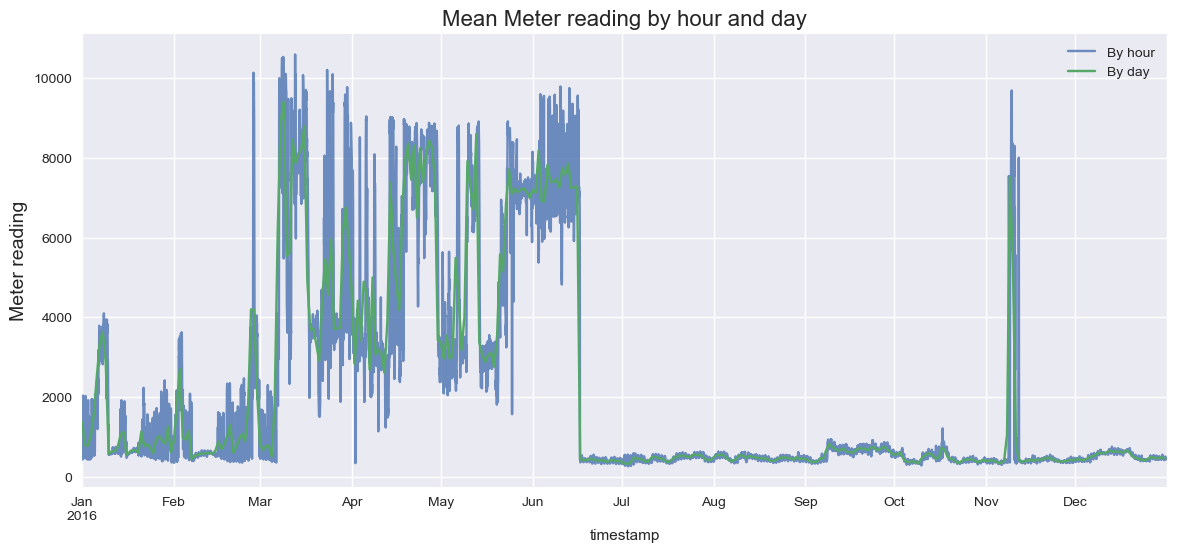

In [7]:
# Mean meter reading by day

fig, axes = plt.subplots(1, 1, figsize=(14, 6), dpi=100)
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='By hour', alpha=0.8).set_ylabel('Meter reading', fontsize=14);
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='By day', alpha=1).set_ylabel('Meter reading', fontsize=14);
axes.set_title('Mean Meter reading by hour and day', fontsize=16);
axes.legend();

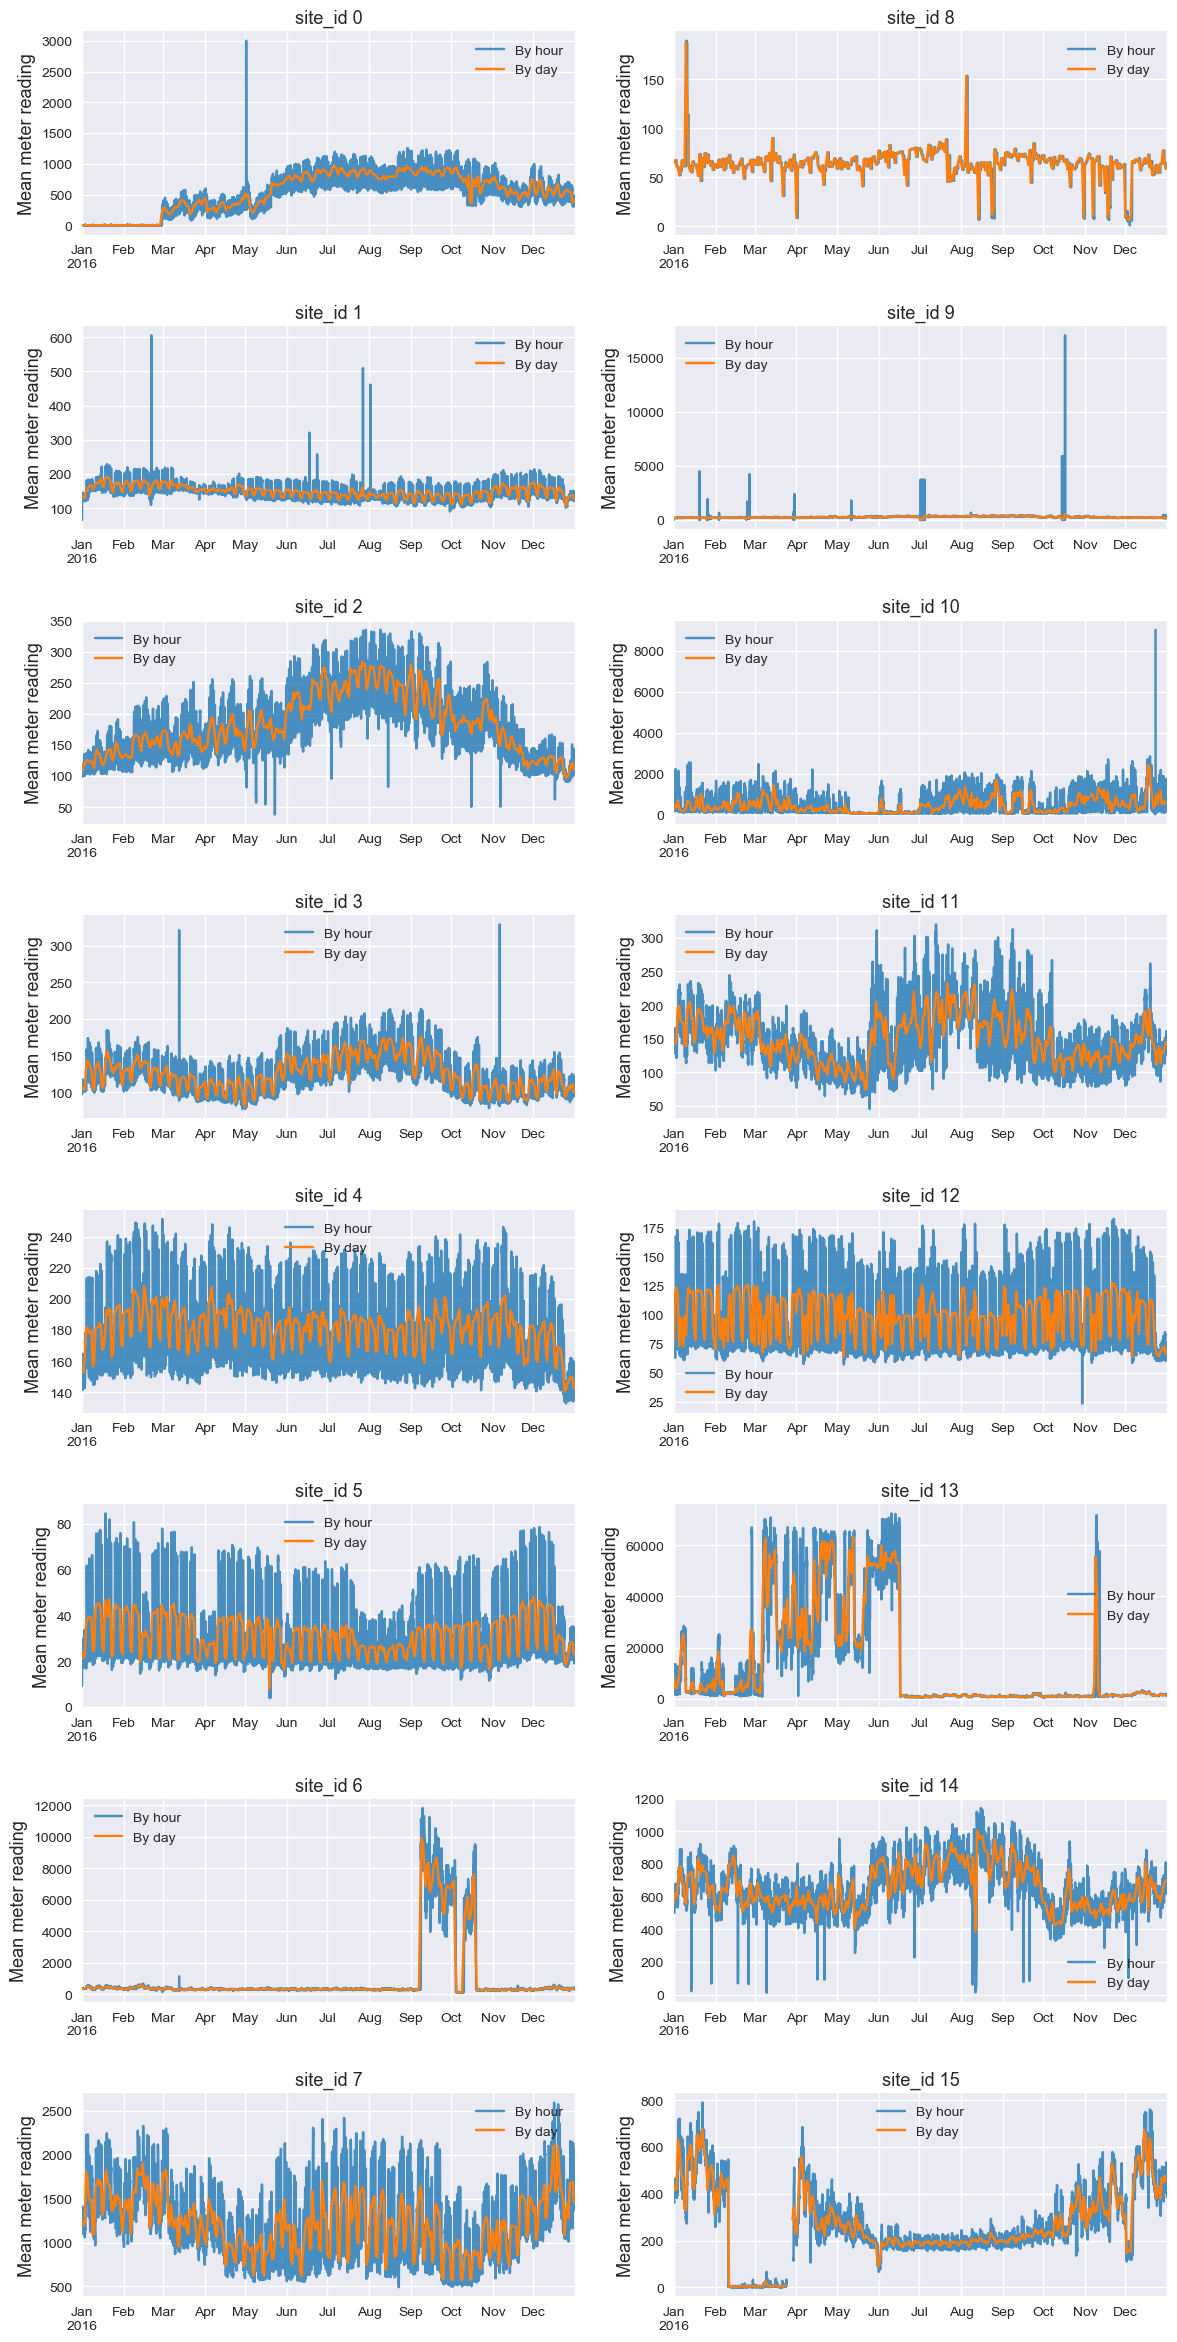

In [11]:
# Mean meter reading by site_id
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
for i in range(train['site_id'].nunique()):
    train[train['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    train[train['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange').set_xlabel('');
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=13);
    plt.subplots_adjust(hspace=0.45)

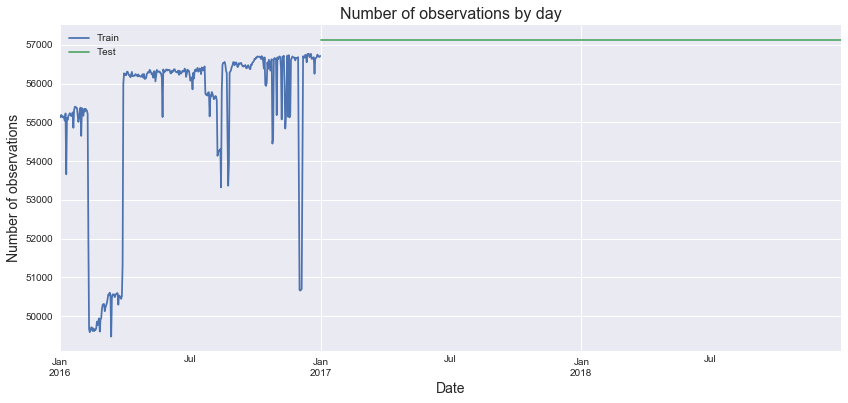

In [14]:
# Number of observations by day
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
train['timestamp'].dt.floor('d').value_counts().sort_index().plot(ax=axes).set_xlabel('Date', fontsize=14);
test['timestamp'].dt.floor('d').value_counts().sort_index().plot(ax=axes).set_ylabel('Number of observations', fontsize=14);
axes.set_title('Number of observations by day', fontsize=16);
axes.legend(['Train', 'Test']);

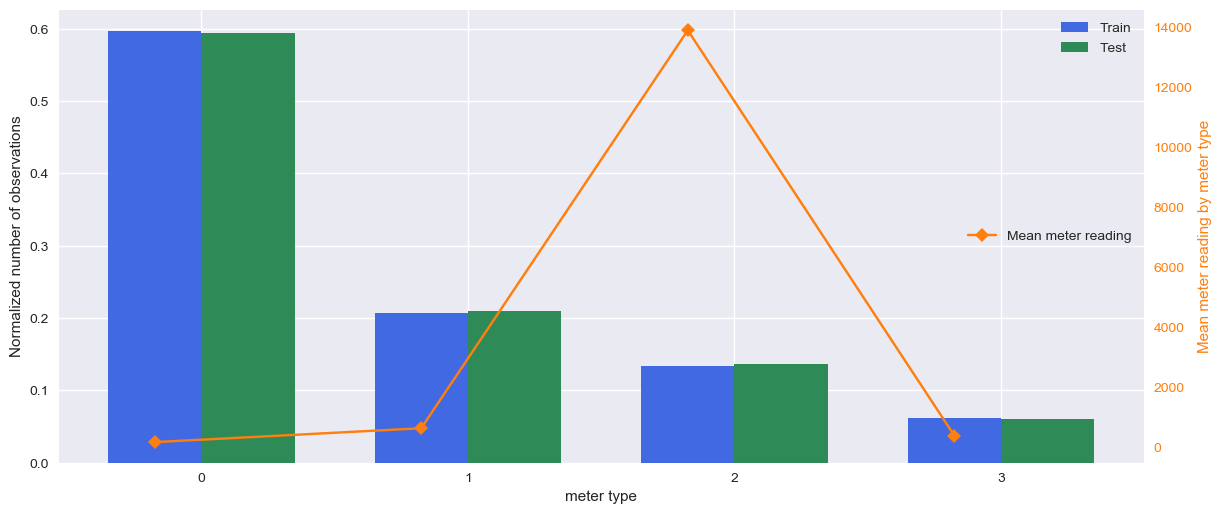

In [15]:
# meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, hotwater: 3}. Not every building has all meter type

train_data = train['meter'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['meter'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('meter type');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['meter'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['meter', 'meter_reading']].groupby('meter')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by meter type', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=5, facecolor='white');

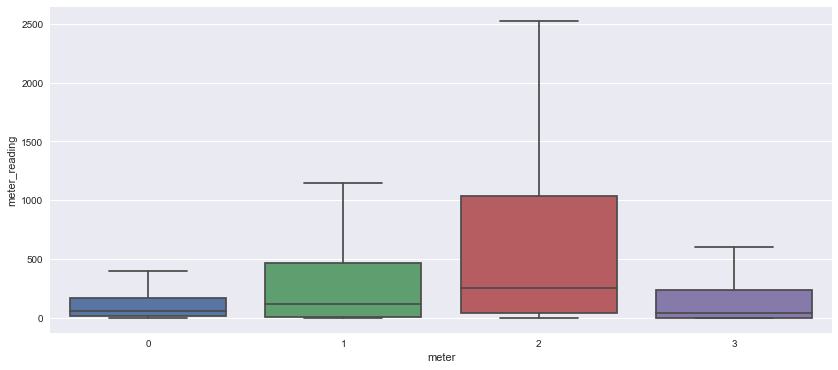

In [16]:
# Box plot of meter reading by meter type with outliers removed

fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='meter', y='meter_reading', data=train, showfliers=False);

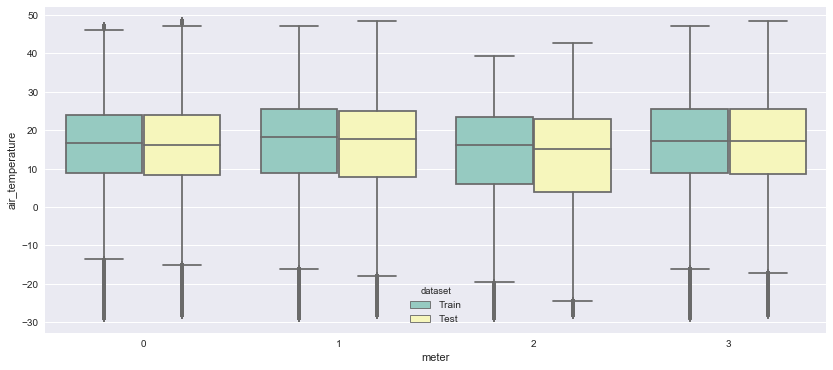

In [17]:
# Box plot of air temperature by meter type

tmp_df = pd.concat([train[['meter', 'air_temperature']], test[['meter', 'air_temperature']]], ignore_index=True)
tmp_df['dataset'] = 'Train'
tmp_df.loc[tmp_df.index > len(train), 'dataset'] = 'Test'

fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='meter', y='air_temperature', data=tmp_df, hue='dataset', palette="Set3");

del tmp_df
gc.collect();

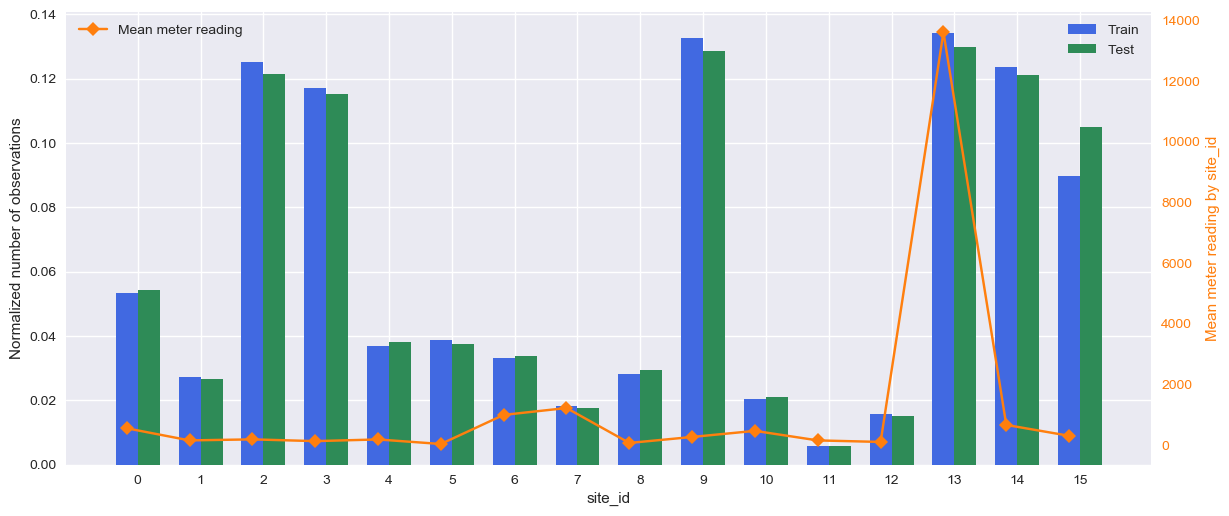

In [18]:
# site_id

train_data = train['site_id'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['site_id'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('site_id');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['site_id'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['site_id', 'meter_reading']].groupby('site_id')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by site_id', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

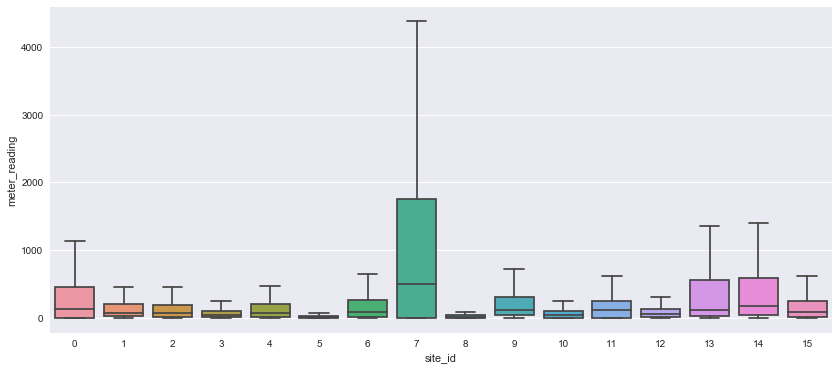

In [19]:
# Box plot of meter reading by site_id with outliers removed

fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='site_id', y='meter_reading', data=train, showfliers=False);

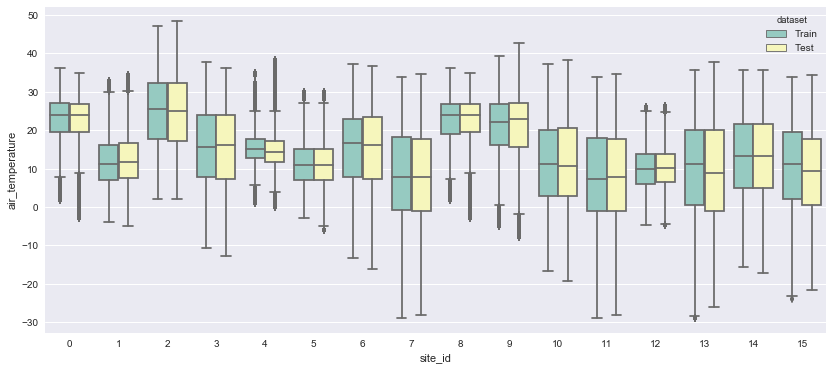

In [20]:
# Box plot of air temperature by site_id

tmp_df = pd.concat([train[['site_id', 'air_temperature']], test[['site_id', 'air_temperature']]], ignore_index=True)
tmp_df['dataset'] = 'Train'
tmp_df.loc[tmp_df.index > len(train), 'dataset'] = 'Test'

fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='site_id', y='air_temperature', data=tmp_df, hue='dataset', palette="Set3");

del tmp_df
gc.collect();

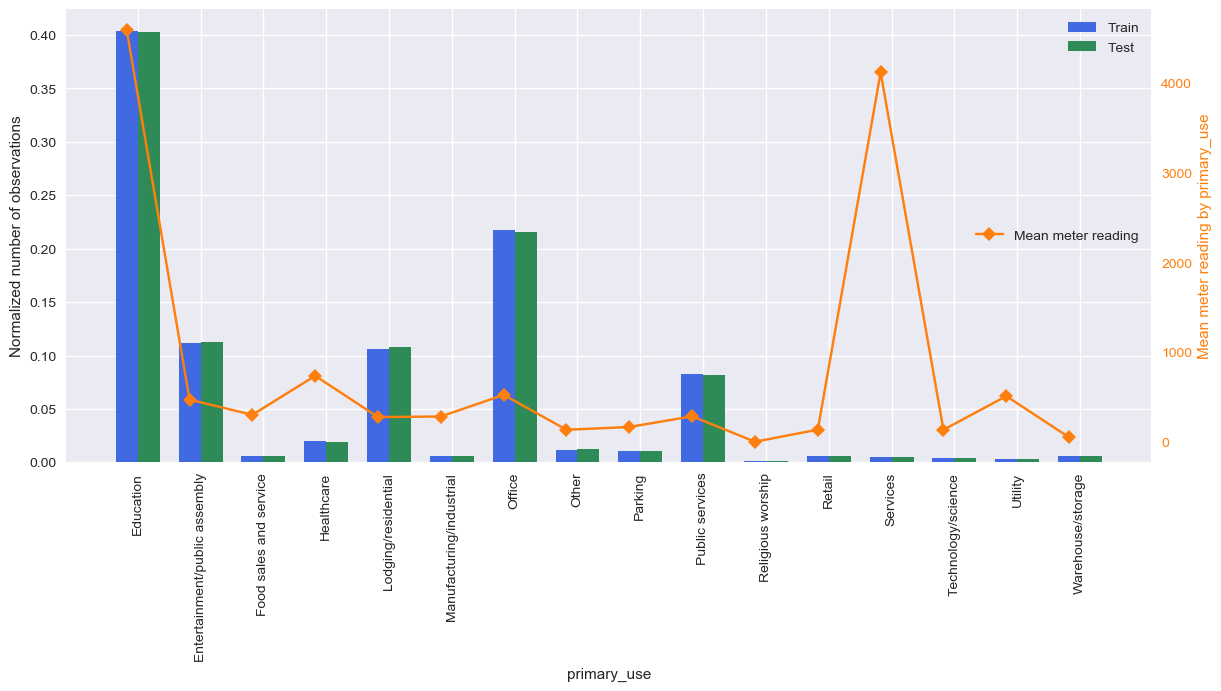

In [21]:
train_data = train['primary_use'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['primary_use'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('primary_use');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['primary_use'].value_counts().sort_index().index, rotation=90)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['primary_use', 'meter_reading']].groupby('primary_use')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by primary_use', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=5, facecolor='white');

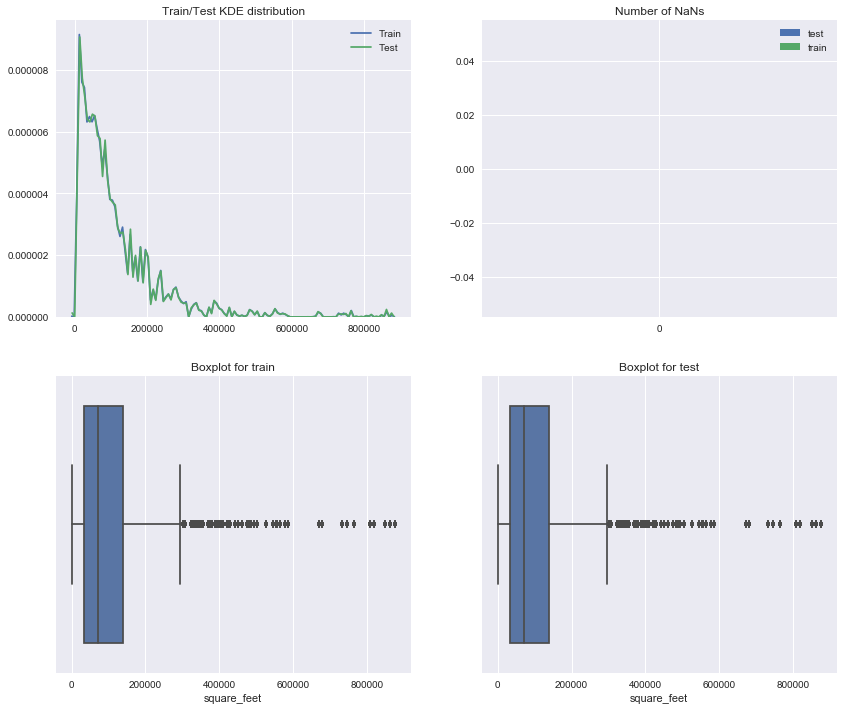

In [22]:
# square_feet - Gross floor area of the building

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
sns.kdeplot(train['square_feet'], ax=axes[0][0], label='Train');
sns.kdeplot(test['square_feet'], ax=axes[0][0], label='Test');
sns.boxplot(x=train['square_feet'], ax=axes[1][0]);
sns.boxplot(x=test['square_feet'], ax=axes[1][1]);
pd.DataFrame({'train': [train['square_feet'].isnull().sum()], 'test': [test['square_feet'].isnull().sum()]}).plot(kind='bar', rot=0, ax=axes[0][1]);
axes[0][0].legend();
axes[0][0].set_title('Train/Test KDE distribution');
axes[0][1].set_title('Number of NaNs');
axes[1][0].set_title('Boxplot for train');
axes[1][1].set_title('Boxplot for test');
gc.collect();

In [23]:
print(train[train['building_id'] == 0]['square_feet'].value_counts())
print(train[train['building_id'] == 1]['square_feet'].value_counts())
print(train[train['building_id'] == 100]['square_feet'].value_counts())

7432    8784
Name: square_feet, dtype: int64
2720    8784
Name: square_feet, dtype: int64
24456    8784
Name: square_feet, dtype: int64


In [24]:
train[['building_id', 'square_feet']].sort_index(by='building_id')

,building_id,square_feet
0,0,7432
4232656,0,7432
...,...,...
7908496,1448,92271
20216099,1448,92271


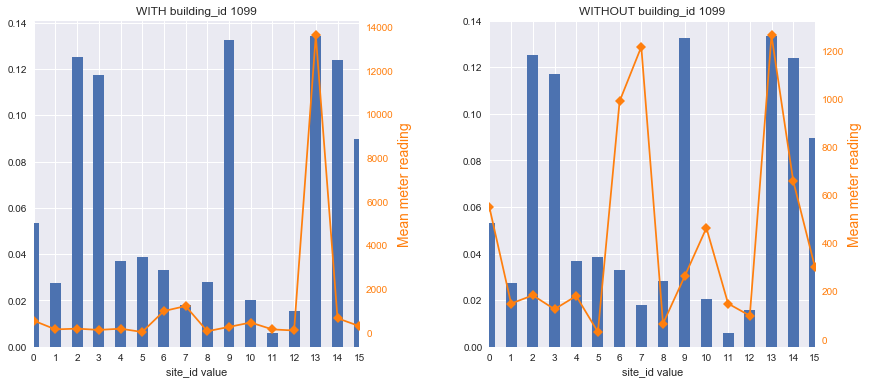

In [26]:
# plot mean energy consumption by site_id WITH and WITHOUT this particular building included

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
train['site_id'].value_counts(dropna=False, normalize=True).sort_index().plot(kind='bar', rot=0, ax=axes[0]).set_xlabel('site_id value');
train[train['building_id']!=1099]['site_id'].value_counts(dropna=False, normalize=True).sort_index().plot(kind='bar', rot=0, ax=axes[1]).set_xlabel('site_id value');
ax2 = axes[0].twinx()
ax3 = axes[1].twinx()
train.groupby('site_id')['meter_reading'].mean().sort_index().plot(ax=ax2, style='D-', grid=False, color='tab:orange');
train[train['building_id']!=1099].groupby('site_id')['meter_reading'].mean().sort_index().plot(ax=ax3, style='D-', grid=False, color='tab:orange');
ax2.set_ylabel('Mean meter reading', color='tab:orange', fontsize=14);
ax3.set_ylabel('Mean meter reading', color='tab:orange', fontsize=14);
ax2.tick_params(axis='y', labelcolor='tab:orange');
ax3.tick_params(axis='y', labelcolor='tab:orange');
plt.subplots_adjust(wspace=0.4)
axes[0].set_title('WITH building_id 1099');
axes[1].set_title('WITHOUT building_id 1099');

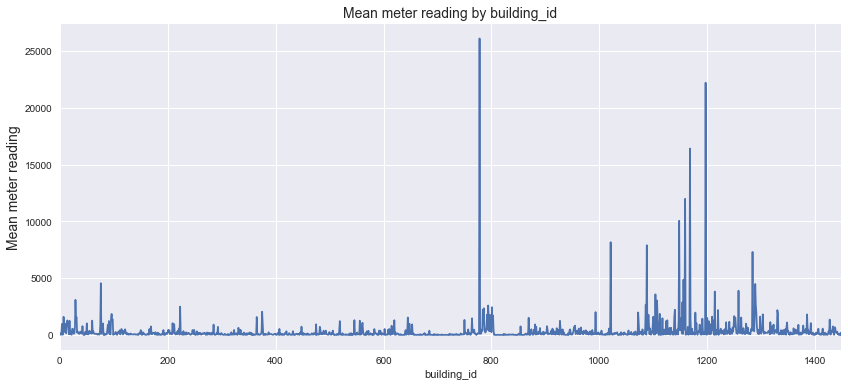

In [27]:
# Mean meter reading by building_id WITHOUT building_id 1099

fig, axes = plt.subplots(1,1,figsize=(14, 6))
train[train['building_id'] != 1099].groupby('building_id')['meter_reading'].mean().plot();
axes.set_title('Mean meter reading by building_id', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);


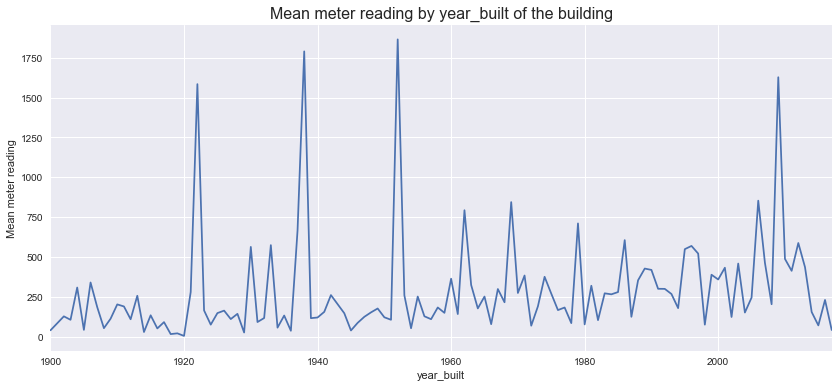

In [29]:
# Mean meter reading by year_built of the building

fig, axes = plt.subplots(1,1,figsize=(14, 6))
train.groupby('year_built')['meter_reading'].mean().plot().set_ylabel('Mean meter reading');
axes.set_title('Mean meter reading by year_built of the building', fontsize=16);

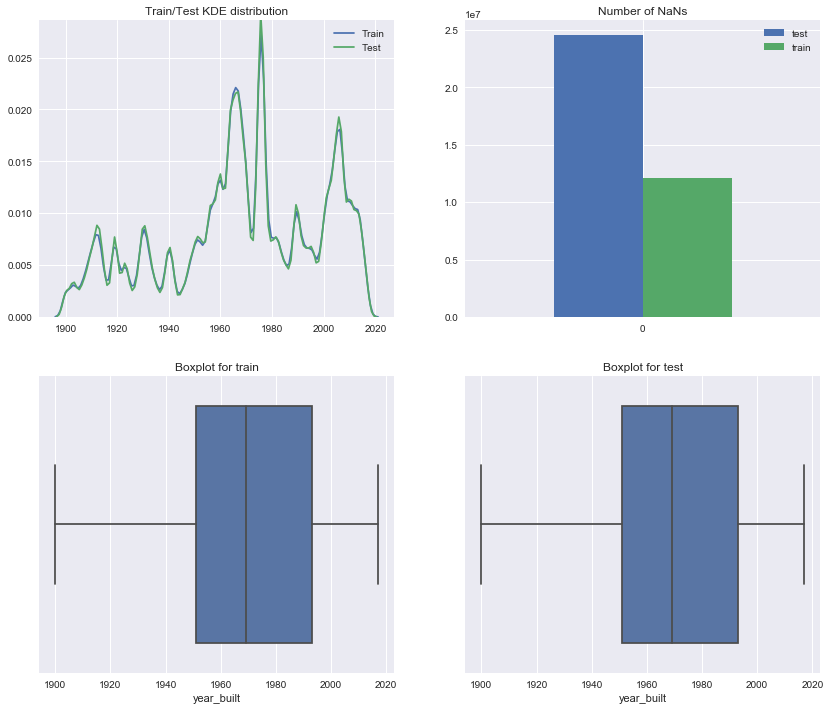

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
sns.kdeplot(train['year_built'], ax=axes[0][0], label='Train');
sns.kdeplot(test['year_built'], ax=axes[0][0], label='Test');
sns.boxplot(x=train['year_built'], ax=axes[1][0]);
sns.boxplot(x=test['year_built'], ax=axes[1][1]);
pd.DataFrame({'train': [train['year_built'].isnull().sum()], 'test': [test['year_built'].isnull().sum()]}).plot(kind='bar', rot=0, ax=axes[0][1]);
axes[0][0].legend();
axes[0][0].set_title('Train/Test KDE distribution');
axes[0][1].set_title('Number of NaNs');
axes[1][0].set_title('Boxplot for train');
axes[1][1].set_title('Boxplot for test');
gc.collect();

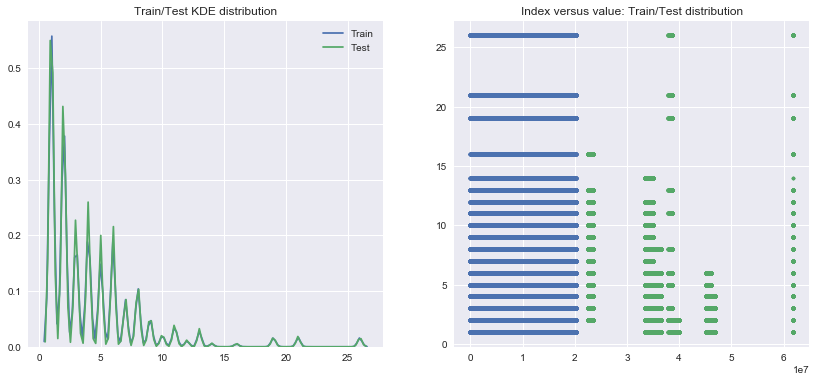

In [31]:
# floor_count - Number of floors of the building

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.kdeplot(train['floor_count'], label='Train', ax=axes[0]);
sns.kdeplot(test['floor_count'], label='Test', ax=axes[0]);
test.index += len(train)
axes[1].plot(train['floor_count'], '.', label='Train');
axes[1].plot(test['floor_count'], '.', label='Test');
test.index -= len(train)
axes[0].set_title('Train/Test KDE distribution');
axes[1].set_title('Index versus value: Train/Test distribution');
gc.collect();